In [1]:
import os
import re
import math
import string
import requests
import json
from itertools import product
from inspect import getsourcefile

In [2]:
# ##Constants##

# (empirically derived mean sentiment intensity rating increase for booster words)
B_INCR = 0.293
B_DECR = -0.293

# (empirically derived mean sentiment intensity rating increase for using ALLCAPs to emphasize a word)
C_INCR = 0.733
N_SCALAR = -0.74

In [3]:
# for removing punctuation
REGEX_REMOVE_PUNCTUATION = re.compile('[%s]' % re.escape(string.punctuation))

PUNC_LIST = [".", "!", "?", ",", ";", ":", "-", "'", "\"",
             "!!", "!!!", "??", "???", "?!?", "!?!", "?!?!", "!?!?"]
NEGATE = \
    ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt",
     "ain't", "aren't", "can't", "couldn't", "daren't", "didn't", "doesn't",
     "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "neither",
     "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
     "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing", "nowhere",
     "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
     "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't",
     "without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite"]

In [4]:
# booster/dampener 'intensifiers' or 'degree adverbs'
# http://en.wiktionary.org/wiki/Category:English_degree_adverbs

BOOSTER_DICT = \
    {"absolutely": B_INCR, "amazingly": B_INCR, "awfully": B_INCR, "completely": B_INCR, 
     "considerably": B_INCR,
     "decidedly": B_INCR, "deeply": B_INCR, "effing": B_INCR, "enormously": B_INCR,
     "entirely": B_INCR, "especially": B_INCR, "exceptionally": B_INCR, "extremely": B_INCR,
     "fabulously": B_INCR, "flipping": B_INCR, "flippin": B_INCR,
     "fricking": B_INCR, "frickin": B_INCR, "frigging": B_INCR, "friggin": B_INCR, "fully": B_INCR, 
     "fucking": B_INCR,
     "greatly": B_INCR, "hella": B_INCR, "highly": B_INCR, "hugely": B_INCR, "incredibly": B_INCR,
     "intensely": B_INCR, "majorly": B_INCR, "more": B_INCR, "most": B_INCR, "particularly": B_INCR,
     "purely": B_INCR, "quite": B_INCR, "really": B_INCR, "remarkably": B_INCR,
     "so": B_INCR, "substantially": B_INCR,
     "thoroughly": B_INCR, "totally": B_INCR, "tremendously": B_INCR,
     "uber": B_INCR, "unbelievably": B_INCR, "unusually": B_INCR, "utterly": B_INCR,
     "very": B_INCR,
     "almost": B_DECR, "barely": B_DECR, "hardly": B_DECR, "just enough": B_DECR,
     "kind of": B_DECR, "kinda": B_DECR, "kindof": B_DECR, "kind-of": B_DECR,
     "less": -5, "little": B_DECR, "marginally": B_DECR, "occasionally": B_DECR, "partly": B_DECR,
     "scarcely": B_DECR, "slightly": B_DECR, "somewhat": B_DECR,
     "sort of": B_DECR, "sorta": B_DECR, "sortof": B_DECR, "sort-of": B_DECR}


In [5]:
# check for special case idioms containing lexicon words
SPECIAL_CASE_IDIOMS = {"the shit": 3, "the bomb": 3, "bad ass": 1.5, "yeah right": -2,
                       "kiss of death": -1.5, "work life balance" : 1.5}


In [6]:
# #Static methods# #

def negated(input_words, include_nt=True):
    """
    Determine if input contains negation words
    """
    input_words = [str(w).lower() for w in input_words]
    neg_words = []
    neg_words.extend(NEGATE)
    for word in neg_words:
        if word in input_words:
            return True
    if include_nt:
        for word in input_words:
            if "n't" in word:
                return True
    if "least" in input_words:
        i = input_words.index("least")
        if i > 0 and input_words[i - 1] != "at":
            return True
    return False

In [7]:
def normalize(score, alpha=15):
    """
    Normalize the score to be between -1 and 1 using an alpha that
    approximates the max expected value
    """
    norm_score = score / math.sqrt((score * score) + alpha)
    if norm_score < -1.0:
        return -1.0
    elif norm_score > 1.0:
        return 1.0
    else:
        return norm_score

In [8]:
def allcap_differential(words):
    """
    Check whether just some words in the input are ALL CAPS
    :param list words: The words to inspect
    :returns: `True` if some but not all items in `words` are ALL CAPS
    """
    is_different = False
    allcap_words = 0
    for word in words:
        if word.isupper():
            allcap_words += 1
    cap_differential = len(words) - allcap_words
    if 0 < cap_differential < len(words):
        is_different = True
    return is_different

In [9]:
def scalar_inc_dec(word, valence, is_cap_diff):
    """
    Check if the preceding words increase, decrease, or negate/nullify the
    valence
    """
    scalar = 0.0
    word_lower = word.lower()
    if word_lower in BOOSTER_DICT:
        scalar = BOOSTER_DICT[word_lower]
        if valence < 0:
            scalar *= -1
        # check if booster/dampener word is in ALLCAPS (while others aren't)
        if word.isupper() and is_cap_diff:
            if valence > 0:
                scalar += C_INCR
            else:
                scalar -= C_INCR
    return scalar

In [10]:
class SentiText(object):
    """
    Identify sentiment-relevant string-level properties of input text.
    """

    def __init__(self, text):
        if not isinstance(text, str):
            text = str(text).encode('utf-8')
        self.text = text
        self.words_and_emoticons = self._words_and_emoticons()
        # doesn't separate words from\
        # adjacent punctuation (keeps emoticons & contractions)
        self.is_cap_diff = allcap_differential(self.words_and_emoticons)
        
    def _words_plus_punc(self):
        """
        Returns mapping of form:
        {
            'cat,': 'cat',
            ',cat': 'cat',
        }
        """
        no_punc_text = REGEX_REMOVE_PUNCTUATION.sub('', self.text)
        
        # removes punctuation (but loses emoticons & contractions)
        words_only = no_punc_text.split()
        
        # remove singletons
        words_only = set(w for w in words_only if len(w) > 1)
        
        # the product gives ('cat', ',') and (',', 'cat')
        punc_before = {''.join(p): p[1] for p in product(PUNC_LIST, words_only)}
        punc_after = {''.join(p): p[0] for p in product(words_only, PUNC_LIST)}
        words_punc_dict = punc_before
        words_punc_dict.update(punc_after)
        return words_punc_dict

    def _words_and_emoticons(self):
        """
        Removes leading and trailing puncutation
        Leaves contractions and most emoticons
            Does not preserve punc-plus-letter emoticons (e.g. :D)
        """
        wes = self.text.split()
        words_punc_dict = self._words_plus_punc()
        wes = [we for we in wes if len(we) > 1]
        
        for i, we in enumerate(wes):
            if we in words_punc_dict:
                wes[i] = words_punc_dict[we]
        return wes


In [11]:
class SentimentIntensityAnalyzer(object):
    """
    Give a sentiment intensity score to sentences.
    """
    def __init__(self, lexicon_file="vader_lexicon.txt", emoji_lexicon="emoji_utf8_lexicon.txt"):
        
        _this_module_file_path_ = os.path.abspath(getsourcefile(lambda: 0))
        
        lexicon_full_filepath = os.path.join(os.path.dirname(_this_module_file_path_), lexicon_file)
        
        with open(lexicon_full_filepath, encoding='utf-8') as f:
            self.lexicon_full_filepath = f.read()
        self.lexicon = self.make_lex_dict()

        emoji_full_filepath = os.path.join(os.path.dirname(_this_module_file_path_), emoji_lexicon)
        with open(emoji_full_filepath, encoding='utf-8') as f:
            self.emoji_full_filepath = f.read()
        self.emojis = self.make_emoji_dict()
        
    def make_lex_dict(self):
        """
        Convert lexicon file to a dictionary
        """
        lex_dict = {}
        for line in self.lexicon_full_filepath.split('\n'):
            sp = line.strip().split('\t')
            if(len(sp) > 1):
                (word, measure) = line.strip().split('\t')[0:2]
                lex_dict[word] = float(measure)
        return lex_dict

    def make_emoji_dict(self):
        """
        Convert emoji lexicon file to a dictionary
        """
        emoji_dict = {}
        for line in self.emoji_full_filepath.split('\n'):
            (emoji, description) = line.strip().split('\t')[0:2]
            emoji_dict[emoji] = description
        return emoji_dict

    def polarity_scores(self, text):
        """
        Return a float for sentiment strength based on the input text.
        Positive values are positive valence, negative value are negative
        valence.
        """
        # convert emojis to their textual descriptions
        text_token_list = text.split()
        
        text_no_emoji_lst = []
        
        for token in text_token_list:
            if token in self.emojis:
                # get the textual description
                description = self.emojis[token]
                text_no_emoji_lst.append(description)
            else:
                text_no_emoji_lst.append(token)
        text = " ".join(x for x in text_no_emoji_lst)
        
        sentitext = SentiText(text)
        
        sentiments = []
        words_and_emoticons = sentitext.words_and_emoticons
        
        for item in words_and_emoticons:
            valence = 0
            i = words_and_emoticons.index(item)
            # check for vader_lexicon words that may be used as modifiers or negations
            
            if item.lower() in BOOSTER_DICT:
                sentiments.append(valence)
                continue
            if (i < len(words_and_emoticons) - 1 and item.lower() == "kind" and
                    words_and_emoticons[i + 1].lower() == "of"):
                sentiments.append(valence)
                continue
            
            sentiments = self.sentiment_valence(valence, sentitext, item, i, sentiments)
            

        sentiments = self._but_check(words_and_emoticons, sentiments)

        valence_dict = self.score_valence(sentiments, text)
        return valence_dict

    def sentiment_valence(self, valence, sentitext, item, i, sentiments):
        is_cap_diff = sentitext.is_cap_diff
        words_and_emoticons = sentitext.words_and_emoticons
        
        item_lowercase = item.lower()
        if item_lowercase in self.lexicon:
            # get the sentiment valence
            valence = self.lexicon[item_lowercase]
            # check if sentiment laden word is in ALL CAPS (while others aren't)
            if item.isupper() and is_cap_diff:
                if valence > 0:
                    valence += C_INCR
                else:
                    valence -= C_INCR
            
            for start_i in range(0, 3):
                # dampen the scalar modifier of preceding words and emoticons
                # (excluding the ones that immediately preceed the item) based
                # on their distance from the current item.
                if i > start_i and words_and_emoticons[i - (start_i + 1)].lower() not in self.lexicon:
                    s = scalar_inc_dec(words_and_emoticons[i - (start_i + 1)], valence, is_cap_diff)
                    if start_i == 1 and s != 0:
                        s = s * 0.95
                    if start_i == 2 and s != 0:
                        s = s * 0.9
                    
                    valence = valence + s
                    valence = self._negation_check(valence, words_and_emoticons, start_i, i)
                    
            valence = self._least_check(valence, words_and_emoticons, i)
        sentiments.append(valence)
        return sentiments

    def _least_check(self, valence, words_and_emoticons, i):
        # check for negation case using "least"
        if i > 1 and words_and_emoticons[i - 1].lower() not in self.lexicon \
                and words_and_emoticons[i - 1].lower() == "least":
            if words_and_emoticons[i - 2].lower() != "at" and words_and_emoticons[i - 2].lower() != "very":
                valence = valence * N_SCALAR
        elif i > 0 and words_and_emoticons[i - 1].lower() not in self.lexicon \
                and words_and_emoticons[i - 1].lower() == "least":
            valence = valence * N_SCALAR
        elif i > 0 and words_and_emoticons[i - 1].lower() not in self.lexicon \
                and words_and_emoticons[i - 1].lower() == "poor":
            valence = valence * N_SCALAR
        return valence

    @staticmethod
    def _but_check(words_and_emoticons, sentiments):
        # check for modification in sentiment due to contrastive conjunction 'but'
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        if 'but' in words_and_emoticons_lower:
            bi = words_and_emoticons_lower.index('but')
            for sentiment in sentiments:
                si = sentiments.index(sentiment)
                if si < bi:
                    sentiments.pop(si)
                    sentiments.insert(si, sentiment * 0.5)
                elif si > bi:
                    sentiments.pop(si)
                    sentiments.insert(si, sentiment * 1.5)
        return sentiments

    @staticmethod
    def _negation_check(valence, words_and_emoticons, start_i, i):
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        if start_i == 0:
            if negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 1 word preceding lexicon word (w/o stopwords)
                valence = valence * N_SCALAR
        if start_i == 1:
            if words_and_emoticons_lower[i - 2] == "never" and \
                    (words_and_emoticons_lower[i - 1] == "so" or
                     words_and_emoticons_lower[i - 1] == "this"):
                valence = valence * 1.25
            elif words_and_emoticons_lower[i - 2] == "without" and \
                    words_and_emoticons_lower[i - 1] == "doubt":
                valence = valence
            elif negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 2 words preceding the lexicon word position
                valence = valence * N_SCALAR
        if start_i == 2:
            if words_and_emoticons_lower[i - 3] == "never" and \
                    (words_and_emoticons_lower[i - 2] == "so" or words_and_emoticons_lower[i - 2] == "this") or \
                    (words_and_emoticons_lower[i - 1] == "so" or words_and_emoticons_lower[i - 1] == "this"):
                valence = valence * 1.25
            elif words_and_emoticons_lower[i - 3] == "without" and \
                    (words_and_emoticons_lower[i - 2] == "doubt" or words_and_emoticons_lower[i - 1] == "doubt"):
                valence = valence
            elif negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 3 words preceding the lexicon word position
                valence = valence * N_SCALAR
        return valence

    
    @staticmethod
    def _sift_sentiment_scores(sentiments):
        # want separate positive versus negative sentiment scores
        pos_sum = 0.0
        neg_sum = 0.0
        neu_count = 0
        for sentiment_score in sentiments:
            if sentiment_score > 0:
                pos_sum += (float(sentiment_score) + 1)  # compensates for neutral words that are counted as 1
            if sentiment_score < 0:
                neg_sum += (float(sentiment_score) - 1)  # when used with math.fabs(), compensates for neutrals
            if sentiment_score == 0:
                neu_count += 1
        return pos_sum, neg_sum, neu_count

    def score_valence(self, sentiments, text):
        
        if sentiments:
            sum_s = float(sum(sentiments))
           
            compound = normalize(sum_s)
            
            # discriminate between positive, negative and neutral sentiment scores
            pos_sum, neg_sum, neu_count = self._sift_sentiment_scores(sentiments)

            total = pos_sum + math.fabs(neg_sum) + neu_count
            
            pos = math.fabs(pos_sum / total)
            neg = math.fabs(neg_sum / total)
            neu = math.fabs(neu_count / total)

        else:
            compound = 0.0
            pos = 0.0
            neg = 0.0
            neu = 0.0

        sentiment_dict = \
            {"neg": round(neg, 3),
             "pos": round(pos, 3),
             "compound": round(compound, 4)}

        return sentiment_dict

In [16]:
analyzer = SentimentIntensityAnalyzer()
# vs = analyzer.polarity_scores("What a great day: I lost my car, my bike was stolen and now you have ruined my expensive painting.")
vs = analyzer.polarity_scores("I wasn't super impressed with that movie.")
print(vs)

{'pos': 0.0, 'neu': 0.412, 'neg': 0.588, 'compound': -0.6908}


In [84]:
analyzer = SentimentIntensityAnalyzer()
# vs = analyzer.polarity_scores("What a great day: I lost my car, my bike was stolen and now you have ruined my expensive painting.")
vs = analyzer.polarity_scores("improvise")
print(vs)

{'pos': 0.0, 'neu': 1.0, 'neg': 0.0, 'compound': 0.0}


In [132]:
import pandas as pd

reviewes = pd.read_csv("data.csv", encoding='utf-16', header=0)


In [208]:
negReviews = {}
posReviews = {}
allReviews = {}
col = {}
for index, row in reviewes.iterrows():
    vs = analyzer.polarity_scores(row[0])
    if vs['neu'] > 0.5:
        allReviews[row[0]] = vs['neu']
        col[row[0]] = 0
    elif vs['neg'] > vs['pos']:
        negReviews[row[0]] = vs['neg']
        allReviews[row[0]] = vs['neg']
        col[row[0]] = -1
    else:
        posReviews[row[0]] = vs['pos']
        allReviews[row[0]] = vs['pos']
        col[row[0]] = 1


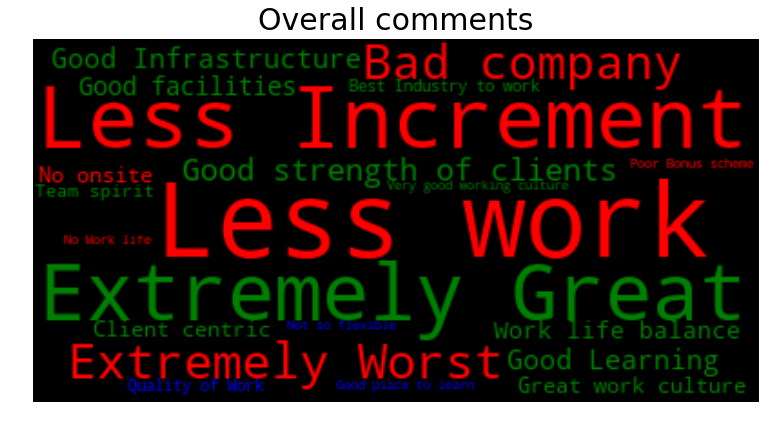

In [218]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def my_tf_color_func(dictionary):
    def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        if dictionary[word] == 1:
            return "green"
        elif dictionary[word] == -1:
            return "red"
        else:
            return "blue"
    return my_tf_color_func_inner


wordcloud = WordCloud( background_color="black", color_func=my_tf_color_func(col)
).generate_from_frequencies(allReviews)
plt.figure(figsize=(13,10))
plt.title("Overall comments", size=30, y=1.01)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

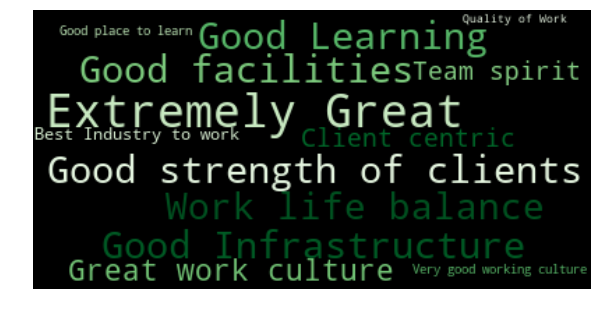

In [182]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud( colormap="Greens"
).generate_from_frequencies(posReviews)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

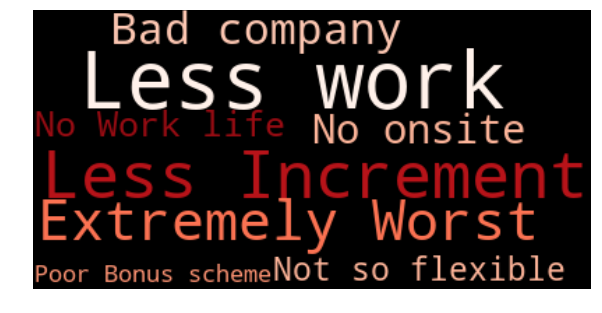

In [190]:
wordcloud = WordCloud(colormap='Reds'
).generate_from_frequencies(negReviews)
plt.figure(figsize=(10,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [179]:
# Display similar reviews : (people also wrote following comments, who wrote this)

variable = str(input("Enter the review to see other reviews by similar users."))


if(variable != ''):
    inputExists = reviewes.loc[reviewes['Reviews'].str.lower().isin([variable.lower()])]
    if len(inputExists) > 0:
        users = inputExists['User'].tolist()
        if len(users) > 0:
            userReviews = reviewes.loc[reviewes['User'].isin(users)]
            print('User, who wrote "',variable,'", also wrote:')
            print("------------------------------------------------")
            res = userReviews.groupby('Reviews')['User'].nunique().sort_values(ascending=False).reset_index(name='count')
            print(res.loc[res['Reviews'].str.lower() != variable.lower()])
    else:
        print("Sorry! input review does not exists in data.")


Enter the review to see other reviews by similar users.Bad company
User, who wrote " Bad company ", also wrote:
------------------------------------------------
                      Reviews  count
0             Extremely Great      2
2           Work life balance      1
3   Very good working culture      1
4                 Team spirit      1
5             Quality of Work      1
6             Not so flexible      1
7              Less Increment      1
8    Good strength of clients      1
9         Good place to learn      1
10            Good facilities      1
11              Good Learning      1
12        Good Infrastructure      1
13      Best Industry to work      1
